In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
from numpy.polynomial import polynomial as P
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# no GM1

name = '_DPPC_DIPC_chol_352'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'

path_data = path
path_res = path

fgro = 'start_mb.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_20micros_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT

name = '_DPPC_DIPC_chol'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/'
path_data = path
path_res = path

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

In [3]:
# load gro and xtc files
u = mda.Universe( path+fgro, path+fxtc)

In [4]:
sel_all = u.select_atoms("all and resname DPPC")
#u.atoms[9400:9401].residues

In [5]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

In [6]:
time_simu = 20 # microseconds
nb_frames_simu = 20000

# Diffusion

In [7]:
# boucle pour suivre un lipide pendant la trajectoire pour calculer le MSD et le coeff de diffusion
tmes = 10

traj_list = []

str_sel = "name PO4 and resname DPPC"

for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            #print(ts.frame)
            
            p = u.select_atoms(str_sel).positions
            traj_list.append(p)
            
print(traj_list)

[array([[397.39    ,  99.57001 ,  73.240005],
       [143.62001 , 219.53001 ,  71.64001 ],
       [ 48.190002, 248.66    ,  70.060005],
       ...,
       [341.37    , 349.53003 ,  32.63    ],
       [293.37003 , 215.75    ,  38.780003],
       [147.31001 ,  82.700005,  32.960003]], dtype=float32), array([[382.91    , 118.850006,  64.86001 ],
       [164.96    , 192.82    ,  75.04    ],
       [ 50.810005, 250.58    ,  69.950005],
       ...,
       [342.97    , 343.49002 ,  34.      ],
       [293.74    , 210.17    ,  27.180002],
       [131.93001 ,  87.40001 ,  40.550003]], dtype=float32), array([[363.74    , 126.      ,  66.350006],
       [151.90001 , 175.8     ,  80.37001 ],
       [ 77.22001 , 249.00002 ,  65.76    ],
       ...,
       [330.84003 , 345.22003 ,  26.030003],
       [306.62    , 215.44    ,  34.18    ],
       [141.61    ,  73.3     ,  49.840004]], dtype=float32), array([[366.99002 , 111.170006,  70.62    ],
       [169.84001 , 190.62    ,  70.53001 ],
       [ 95.

In [8]:
traj = np.array(traj_list)

print(np.shape(traj)) # nb de frames - indice des lipides - coordonnées
print(len(traj[2]))

(2000, 1650, 3)
1650


In [9]:
np.save(path_res+'traj_diffusion'+name+'.npy', traj)

In [10]:
nb_frames = int(nb_frames_simu / tmes)
print(nb_frames)

2000


[164.32    147.28    147.86    ... 338.89    337.33002 345.13   ]


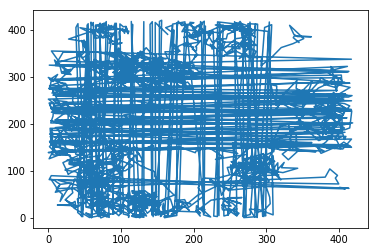

In [11]:
nbr=22 # indice du lipide que l'on suit
x=traj[:,nbr,0]
y=traj[:,nbr,1]
plt.plot(x,y)
print(x)

In [12]:
L = 430

x_ur = np.arange(nb_frames, dtype=float)
y_ur = np.arange(nb_frames, dtype=float)

x_ur[0] = x[0]
y_ur[0] = y[0]

for t in range(1,nb_frames):
    Dx = x[t]-x[t-1]
    if Dx < -L/2 :
        Dx = Dx+L
    if Dx > L/2 :
        Dx = Dx-L
    x_ur[t] = x_ur[t-1] + Dx
    
    Dy = y[t]-y[t-1]
    if Dy < -L/2 :
        Dy = Dy+L
    if Dy > L/2 :
        Dy = Dy-L
    y_ur[t] = y_ur[t-1] + Dy

[164.32000732 147.27999878 147.86000061 ... 338.89002967 337.33003211
 345.1300199 ]
[390.32000732 415.50003052 441.         ... 817.17002544 813.15000591
 803.15000591]


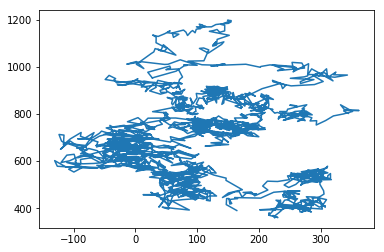

In [13]:
print(x_ur)
print(y_ur)
plt.plot(x_ur,y_ur)

In [14]:
# a voir si on prend à t ini ou quand le domaine est formé
nb_lipids = len(traj[0])
# a la frame initiale, tous les lipides, le lipide avec le plus grand x - le lipid avec le plus petit x
Lx = max(traj[0,:,0])-min(traj[0,:,0])
Ly = max(traj[0,:,1])-min(traj[0,:,1])

L=max(Lx,Ly)
print(L)

423.55002


In [15]:
x_ur = np.arange(nb_frames, dtype=float)
y_ur = np.arange(nb_frames, dtype=float)

smax = 10
#MSD = np.zeros(smax)
MSD_lipids = np.zeros(smax)
MSD_lipids_norm = np.zeros(smax)

for i in range(nb_lipids):
    
    x=traj[:,i,0]
    y=traj[:,i,1]

    x_ur[0] = x[0]
    y_ur[0] = y[0]
    
    for t in range(1,nb_frames):
        Dx = x[t]-x[t-1]
        if Dx < -L/2 :
            Dx = Dx+L
        if Dx > L/2 :
            Dx = Dx-L
        x_ur[t] = x_ur[t-1] + Dx

        Dy = y[t]-y[t-1]
        if Dy < -L/2 :
            Dy = Dy+L
        if Dy > L/2 :
            Dy = Dy-L
        y_ur[t] = y_ur[t-1] + Dy
        
    
    MSD = np.zeros(smax)
    for s in range(smax):
        for t in range(nb_frames-s):
            MSD[s] = MSD[s] + (x_ur[t+s]-x_ur[t])**2 + (y_ur[t+s]-y_ur[t])**2
        MSD[s]=MSD[s]/(nb_frames-s)
        MSD_lipids[s]=MSD_lipids[s]+MSD[s]
        
for s in range(smax):
    MSD_lipids_norm[s] = MSD_lipids[s]/nb_lipids
print(MSD_lipids_norm)

[   0.          234.13504029  427.35119003  615.5962218   801.89138345
  986.3078287  1170.68604411 1353.41286012 1536.18620373 1718.14980875]


[  0.         194.12482441]


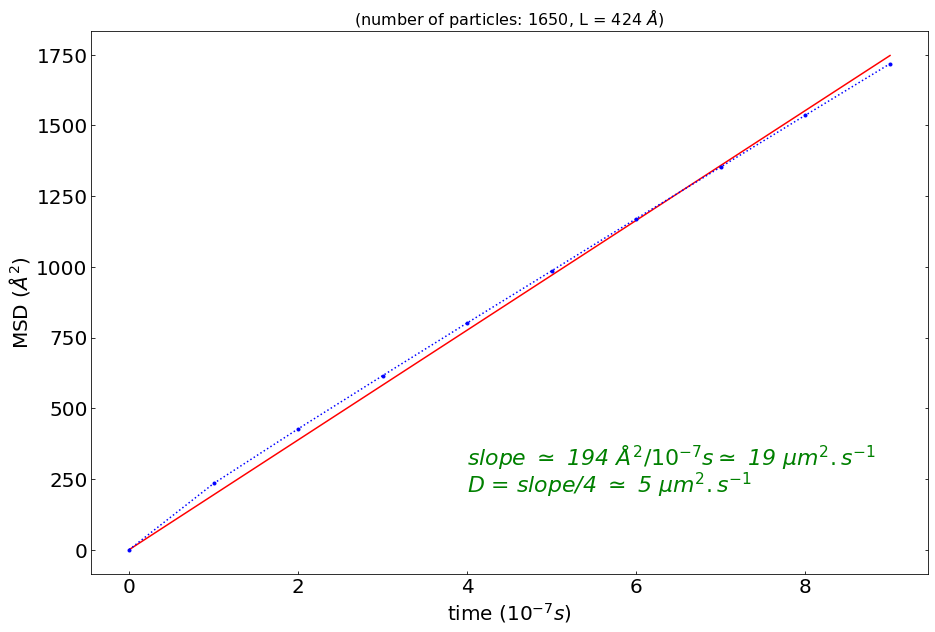

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))

s = np.arange(smax)

pfit = P.polyfit(s, MSD_lipids_norm,[1])
print(pfit)

ax.plot(s,pfit[1]*s+pfit[0], 'red')
ax.plot(s,MSD_lipids_norm, ':b.')
plt.xlabel('time ($10^{-7}s$)', fontsize=20)
plt.ylabel('MSD ($\AA^2$)', fontsize=20)

# *10e-8 pour micro m2 * 10e7 pour /s soit *10e-1 
plt.annotate('slope $\simeq $ %.0f $\AA^2/ 10^{-7}s$$\simeq $ %.0f $\mu m^2.s^{-1}$' % (pfit[1],pfit[1]*0.1), color='g', fontsize=22, style='italic', xy=(8,8), xytext=(4,300))
plt.annotate('D = slope/4 $\simeq$ %.0f $\mu m^2.s^{-1}$' % (pfit[1]*0.1/4), color='g', fontsize=22, style='italic', xy=(8,8), xytext=(4,200))

ax.set_title('(number of particles: %d, L = %.0f $\AA$)' % (nb_lipids, L), fontsize=16)
ax.tick_params(labelsize=20)

ax.xaxis.set_tick_params(direction="in", which="both")
ax.yaxis.set_tick_params(direction="in", right=True, which="both")


plt.savefig(path+'diffusion'+name+'_Lo_long.pdf', format='pdf',bbox_inches='tight')